# Read and analysis slow control data version 2


Updated June 10th 20204

Starting with headers, envorimental varibles, and functions

In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob,os,platform
import datetime,calendar


#varible for determining the lab pc or other pc, Check if windows or not, then try to grab pc name
pcname=""
if platform.system() == "Windows":
    pcname=platform.uname().node
else:
    try:
        pcname=os.uname()[1]
    except:
        print("Issue with finding pc name")

env_var_dataloc ="" #varible for location of waveform data. 
data_dir_mod_old="" #varible for small difference in storage managment between pc 1 and 2
if pcname=='PHYS-PSB02802': #Lab pc 2, (Labview pc)
    env_var_dataloc ="A:/DATA/"
    
elif pcname=="PHYS-PSB02801": #Lab pc 1, (solidworks pc)
    env_var_dataloc ="data/" #This is true for Jason's work atm (June 10th) Needs Updateing to global or user friendly verison
    data_dir_mod_old="/"


TimeZero=datetime.datetime(2023,1,1)


## Functions and def

#### h5 file info

In [2]:
groups = []
datasets = []
atts = {} # attributes

def gather_names_and_atts(name, obj):
    if isinstance(obj, h5py.Group):
        groups.append(name)
    elif isinstance(obj, h5py.Dataset):
        datasets.append(name)
    for key, val in obj.attrs.items():
        atts[name + '/' + key] = val

def list_groups_datasets_atts(file):
    with h5py.File(file, 'r') as f:
        f.visititems(gather_names_and_atts)

def print_lists(list_name):
    i = 0
    for name in list_name:
        print(i, name)
        i=i+1
    print()

def create_dataframe_from_datasets(file_name, dataset_names):

    with h5py.File(file_name, 'r') as f:
        dataset_names =[]
       
        for i in f.keys():
            for j in f[i].keys():
                dataset_names.append(i+"/"+j)
       
        
        dfs = {name: pd.DataFrame(f[name][:])   for name in dataset_names }
    return dfs


def poop():
    with h5py.File(file_name, 'r') as f:
        for name in dataset_names:
            try:
                dfs = {name: pd.DataFrame(f[name][:]) }
            except:
                print("issue with", name)
    return dfs

## Read in file and make dataframe function

In [3]:
channel_list=  ["Flow_Meter" ,"Liquid_Nitro_Valve", "PID_Heater","Pressure_1","Pressure_2",
                "Heater_State","Nitro_Baseline","Nitro_Weigth","Target_Channel","Target_Temperature",
                "Time","Valve_State","Cold_Finger","Nitro_Reservoir","Xe_Cell_1","Xe_Cell_2",
                "Xe_Cell_3","Xe_Cell_Outside","Pressure_Cell","Pressure_Mfold","Storage_1","Storage_2",
                "Pressure_Cryostat","Pressure_Manifold","Pressure_Nitro","Cryostat_Top","Xe_Cell_Bottom","Xe_Cell_Top"]


def getprologue_time(f):
    ''' Argument f == hdf5 file
        returns datetimeobject of time information 
    '''
    atr="Prologue"
    prologue=f.attrs[atr]
    prologue=prologue.replace("\r","")
    splitlog=prologue.split( "\n")
    timeinfostr=splitlog[2]
    timeinfo={}
    timeinfo["year"]=int(timeinfostr[0:4])
    timeinfo["mon"]=int(timeinfostr[4:6])
    timeinfo["day"]=int(timeinfostr[6:8])
    timeinfo["hour"]=int(timeinfostr[8:10])
    timeinfo["min"]=int(timeinfostr[10:12])
    timeinfo["sec"]=int(timeinfostr[12:14])
    
    strtime=""
    for key in timeinfo.keys():
        strtime=strtime+"%s"%(str(timeinfo[key]))
    RunStart_Datetime=datetime.datetime.strptime(strtime, "%Y%m%d%H%M%S") #takes a string in the listed format and turns it into a datetime object


    print(timeinfo, RunStart_Datetime)
    return RunStart_Datetime 

def timetosecs(timeinfo):
    '''argument timeinfo dict returns total seconds for the day
    Need to make this return time from some time in the past to allow for overnight runs'''


    return timeinfo["hour"]*60*60 +timeinfo["min"]*60+timeinfo["sec"]



def calib_dict_wtime(file_name):
    ''' This function grabs the slow control data from the hdf5 file that offsets the time by amount of seconds since Jan 1 2020'''
    fh5= h5py.File(file_name, 'r') 
    timeinfo=getprologue_time(fh5)
    timeoffset=(timeinfo-TimeZero).total_seconds()
    print("Time offset",timeoffset)
    fh5.close()
    list_groups_datasets_atts(file_name)
    dataset_names = datasets # to create a dataframe for each
    datadict = create_dataframe_from_datasets(file_name, dataset_names)
    newdict={}
    l,m,n=-1,-1,-1
    j=0
    js=[-1,-1,-1]
    print(datadict.keys())
    for key in datadict.keys():

        #print(key)
        pos=key.find("/")
        group=key[:pos]
        if group=="omb_daq":
            j=0
            l+=1
            js[0]+=1
        elif group=="pid_info":
            j=1
            m+=1
            js[1]+=1
        elif group=="tc08_daq":
            j=2
            n+=1
            js[2]+=1
        
        m,b=1,0
        s_key=key[pos+1:]

        if s_key =="Pressure_1":
            s_key="Pressure_Cell"
        elif s_key =="Pressure_2":
            s_key="Pressure_Manifold"
        if s_key not in channel_list:
            
           print("Not in channel list " ,s_key)
           # continue

        if s_key=="Inter" or s_key =="Slope":
                continue
        
        else:
            
            #print(group,key, js[j])
            if j==1:
                m,b=1,0
            else:
                try:
                    m = datadict["%s/Slope"%(group)][0][js[j]]
                    b = datadict["%s/Inter"%(group)][0][js[j]]
                except:
                    m,b=1,0
        
            
        #print(m,b, )
        
        newdict[s_key]=datadict[key][0]*m +b
    
    try:
        newdict["Time"] = timeoffset + np.arange(0,len(newdict["Time"])*2,2)
    except:
        newdict["Time"] = timeoffset + np.arange(0,len(newdict[s_key])*2,2)
    
    return newdict



def get_slow_ctr_df(filedate):

    filedes ="slow_control"
    datadir="./data"
    
    try:
        filedate=str(filedate)
    except:
        print("Issue with file date")

    filelist=glob.glob("%s/%s*.h5"%(datadir,filedate))
    print(filelist)
    if len(filelist) <1:
        print("Error with globing files")

    datadicts=[]
    DFs=[]
    for filename in filelist:
      
        finfo=os.stat(filename)
        print(finfo.st_size)
        if finfo.st_size < 18000:
            print("Skipping %s due to size"%(filename))
            continue
        datasets = []
        print(filename)
        datadict=calib_dict_wtime(filename)
        datadicts.append(datadict)
        try:
            DFs.append(pd.DataFrame.from_dict(datadict))
        except:
            print("issue with appending files into list")
        print( "len",len(datadict["Time"]))

    DF = pd.concat(DFs)
    DF =DF.sort_values(by=["Time"])

    return DF




def fixtimeoffset(DFs): 
    '''This function will take a list of '''




In [16]:
def GetAllFiles(date):
    if type(date)==type("str") or type(date) == type(2):
        date_placeholder=date
        date=[]
        date.append(date_placeholder)
    elif type(date) != type(["str","str"]):
        print("Issue with argument - date \n Please use string or list of strings in the format YYYYMMDD")
        return [""]
    file_list=[]
    for d in date:
        search_term=env_var_dataloc+str(d)+"*"
        file_list=file_list+glob.glob(search_term)
    return file_list


def Get_SlowControl_DF_fromlist(filelist):
    if type(filelist)==type("str"):
        filelist_placeholder=filelist
        filelist=[]
        filelist.append(date_placeholder)
    elif type(file_list) != type(["str","str"]):
        print("Issue with argument - date \n Please use string with the filepath")
        return [""]
    slowcontrol_dict_list=[]
    for file in file_list:
        if os.path.getsize(file) <=30000:
            continue
        slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
        DF=pd.concat(slowcontrol_dict_list)
    return DF

def Get_SlowControl_DF(date):
    DF=pd.DataFrame()
    if type(date)==type("str") or type(date) == type(2):
        date_placeholder=date
        date=[]
        date.append(date_placeholder)
    elif type(date) != type(["str","str"]):
        print("Issue with argument - date \n Please use string or list of strings in the format YYYYMMDD")
        return DF
    file_list=GetAllFiles(date)
    slowcontrol_dict_list=[]
    for file in file_list:
        if os.path.getsize(file) <=30000:
            print("Skipping %s"%(file))
            continue
        slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
        DF=pd.concat(slowcontrol_dict_list)
    return DF


In [4]:
filedate="20240522"
filedes ="slow_control"
datadir =env_var_dataloc

filelist=glob.glob("%s%s*.h5"%(datadir,filedate))
print(filelist)

['A:/DATA\\20240522_slow_control.h5', 'A:/DATA\\20240522_slow_control_1.h5', 'A:/DATA\\20240522_slow_control_2.h5', 'A:/DATA\\20240522_slow_control_3.h5', 'A:/DATA\\20240522_slow_control_4.h5', 'A:/DATA\\20240522_slow_control_5.h5', 'A:/DATA\\20240522_slow_control_6.h5']


In [5]:



getprologue_time(h5py.File(file))

NameError: name 'file' is not defined

## Read slowcontrol data - from 20231110

In [6]:
filedate="20240520"
filedes ="slow_control"
datadir =env_var_dataloc

filelist=glob.glob("%s%s*.h5"%(datadir,filedate))

print(filelist)

datadicts=[]
DFs=[]
for filename in filelist:
    datasets = []
    print(filename)
    datadict=calib_dict_wtime(filename)
    datadicts.append(datadict)
    print( "len",len(datadict["Time"]))
    if len(datadict) >=4:
        DFs.append(pd.DataFrame.from_dict(datadict))
    else:
        print(len(pd.DataFrame.from_dict(datadict)), type(pd.DataFrame.from_dict(datadict)))

    







['A:/DATA\\20240520_slow_control.h5', 'A:/DATA\\20240520_slow_control_1.h5', 'A:/DATA\\20240520_slow_control_10.h5', 'A:/DATA\\20240520_slow_control_2.h5', 'A:/DATA\\20240520_slow_control_3.h5', 'A:/DATA\\20240520_slow_control_4.h5', 'A:/DATA\\20240520_slow_control_5.h5', 'A:/DATA\\20240520_slow_control_6.h5', 'A:/DATA\\20240520_slow_control_7.h5', 'A:/DATA\\20240520_slow_control_8.h5', 'A:/DATA\\20240520_slow_control_9.h5']
A:/DATA\20240520_slow_control.h5
{'year': 2024, 'mon': 5, 'day': 20, 'hour': 9, 'min': 17, 'sec': 49} 2024-05-20 09:17:49
Time offset 43665469.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top'

ValueError: array length 0 does not match index length 1

{'Flow_Meter': 0        0.001879
 1        0.001832
 2        0.001666
 3        0.001709
 4        0.001470
            ...   
 63696    0.001629
 63697    0.001448
 63698    0.001731
 63699    0.001675
 63700    0.001734
 Name: 0, Length: 63701, dtype: float64,
 'Liquid_Nitro_Valve': 0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        0.0
         ... 
 63696    0.0
 63697    0.0
 63698    0.0
 63699    0.0
 63700    0.0
 Name: 0, Length: 63701, dtype: float64,
 'PID_Heater': 0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        0.0
         ... 
 63696    0.0
 63697    0.0
 63698    0.0
 63699    0.0
 63700    0.0
 Name: 0, Length: 63701, dtype: float64,
 'Pressure_Cryostat': 0        4.585524
 1        4.585149
 2        4.585608
 3        4.585421
 4        4.587227
            ...   
 63696    6.570799
 63697    6.569961
 63698    6.570638
 63699    6.570001
 63700    6.570621
 Name: 0, Length: 63701, dtype: float64,
 'Pressure_Manifold': 0         9.85228

In [ ]:

def Get_dict_from_hdf5(file_name):
    with h5py.File(file_name, 'r') as f:
        dataset_names =[]
        
        for i in f.keys():
            for j in f[i].keys():
                dataset_names.append(i+"/"+j)
        
        
        dfs = {name: pd.DataFrame(f[name][:])   for name in dataset_names }

    return dfs

In [ ]:
f = h5py.File(file,'r')
for i in f.keys():
    for j in f[i].keys():
        print(f[i+"/"+j][:])
        break

[0.00148535 0.00168085 0.00175714 ... 0.00133562 0.0014286  0.00177336]
[0. 0. 0. ... 0. 0. 0.]
[250.96560669 250.94921875 250.95332336 ... 289.03579712 289.03234863
 289.02877808]


## Read slowcontrol data - from 20240606

In [ ]:
date=20240605
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list=glob.glob(search_term)
date=20240606
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list =file_list + glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=40000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_June06=pd.concat(slowcontrol_dict_list)



['A:/DATA\\20240605_slow_control.h5', 'A:/DATA\\20240605_slow_control_1.h5', 'A:/DATA\\20240605_slow_control_2.h5', 'A:/DATA\\20240605_slow_control_3.h5', 'A:/DATA\\20240605_slow_control_4.h5', 'A:/DATA\\20240605_slow_control_5.h5', 'A:/DATA\\20240605_slow_control_6.h5', 'A:/DATA\\20240606_slow_control.h5', 'A:/DATA\\20240606_slow_control_1.h5', 'A:/DATA\\20240606_slow_control_2.h5', 'A:/DATA\\20240606_slow_control_3.h5', 'A:/DATA\\20240606_slow_control_4.h5']
Time offset 45047858.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1'

## Read slowcontrol data - from 20231110

In [ ]:
date=20231110
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*.h5"
file_list=glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    print(file)
    if os.path.getsize(file) <=40000:
        print("\t\t too small")
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_Nov10=pd.concat(slowcontrol_dict_list)


['A:/DATA\\20231110_slow_control.h5', 'A:/DATA\\20231110_slow_control_1.h5', 'A:/DATA\\20231110_slow_control_10.h5', 'A:/DATA\\20231110_slow_control_11.h5', 'A:/DATA\\20231110_slow_control_12.h5', 'A:/DATA\\20231110_slow_control_13.h5', 'A:/DATA\\20231110_slow_control_14.h5', 'A:/DATA\\20231110_slow_control_15.h5', 'A:/DATA\\20231110_slow_control_16.h5', 'A:/DATA\\20231110_slow_control_17.h5', 'A:/DATA\\20231110_slow_control_18.h5', 'A:/DATA\\20231110_slow_control_19.h5', 'A:/DATA\\20231110_slow_control_2.h5', 'A:/DATA\\20231110_slow_control_20.h5', 'A:/DATA\\20231110_slow_control_21.h5', 'A:/DATA\\20231110_slow_control_3.h5', 'A:/DATA\\20231110_slow_control_4.h5', 'A:/DATA\\20231110_slow_control_5.h5', 'A:/DATA\\20231110_slow_control_6.h5', 'A:/DATA\\20231110_slow_control_7.h5', 'A:/DATA\\20231110_slow_control_8.h5', 'A:/DATA\\20231110_slow_control_9.h5']
A:/DATA\20231110_slow_control.h5
Time offset 27074719.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Val

In [ ]:


date=20240520
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list=glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=40000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_May20=pd.concat(slowcontrol_dict_list)



['A:/DATA\\20240520_slow_control.h5', 'A:/DATA\\20240520_slow_control_1.h5', 'A:/DATA\\20240520_slow_control_10.h5', 'A:/DATA\\20240520_slow_control_2.h5', 'A:/DATA\\20240520_slow_control_3.h5', 'A:/DATA\\20240520_slow_control_4.h5', 'A:/DATA\\20240520_slow_control_5.h5', 'A:/DATA\\20240520_slow_control_6.h5', 'A:/DATA\\20240520_slow_control_7.h5', 'A:/DATA\\20240520_slow_control_8.h5', 'A:/DATA\\20240520_slow_control_9.h5']
Time offset 33469
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell

In [ ]:
date=20240605
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list=glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=30000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_June10=pd.concat(slowcontrol_dict_list)


['A:/DATA\\20240605_slow_control.h5', 'A:/DATA\\20240605_slow_control_1.h5', 'A:/DATA\\20240605_slow_control_2.h5', 'A:/DATA\\20240605_slow_control_3.h5', 'A:/DATA\\20240605_slow_control_4.h5', 'A:/DATA\\20240605_slow_control_5.h5', 'A:/DATA\\20240605_slow_control_6.h5']
Time offset 45047858.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Bottom', 'tc08_daq/Xe_Cell_Outside', 'tc08_daq/Xe_Cell_Top'])
Not in channel list  Inter
Not in channel list  Slope
Not in channel list  Inter
Not in c

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


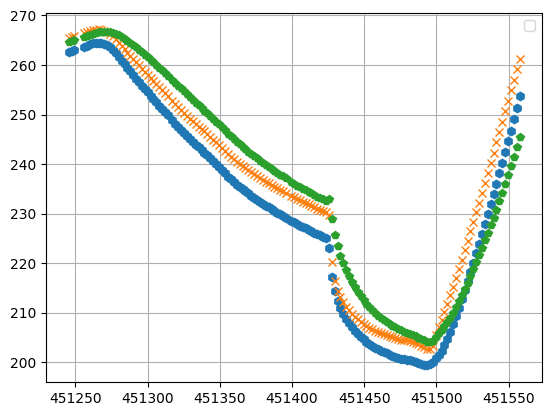

In [ ]:
plt.errorbar(DF_Nov10["Time"][::60]/60.0,DF_Nov10["Xe_Cell_1"][::60], fmt="h")
plt.errorbar(DF_Nov10["Time"][::60]/60.0,DF_Nov10["Xe_Cell_2"][::60], fmt="x")
plt.errorbar(DF_Nov10["Time"][::60]/60.0,DF_Nov10["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


45100800.0


(150.0, 220.0)

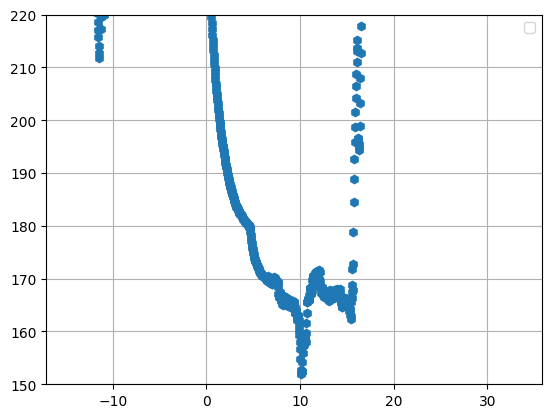

In [ ]:
timeo=(datetime.datetime(2024,6,6)-TimeZero).total_seconds()
print(timeo)

plt.errorbar(x=(DF_June06["Time"][::60]-timeo)/3600.0  , y=DF_June06["Cold_Finger"][::60], fmt="h")
#plt.errorbar(x=(DF_June06["Time"][::60]-timeo)/3600.0, y=DF_June06["Xe_Cell_Top"][::60], fmt="x")
#plt.errorbar(x=(DF_June06["Time"][::60]-timeo)/3600.0, y=DF_June06["Cryostat_Top"][::60], fmt="p")
plt.grid()
plt.legend()

#plt.xlim(7,15)
plt.ylim(150,220)

45100800.0


(7.0, 15.0)

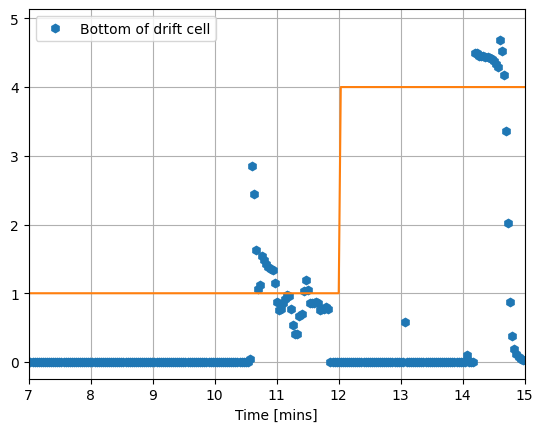

In [ ]:
timeo=(datetime.datetime(2024,6,6)-TimeZero).total_seconds()
print(timeo)


plt.errorbar(x=(DF_June06["Time"][::60]-timeo)/3600.0  , y=DF_June06["Flow_Meter"][::60], fmt="h", label="Bottom of drift cell")
plt.errorbar(x=(DF_June06["Time"][::60]-timeo)/3600.0  , y=DF_June06["Target_Channel"][::60])

June5_dt = datetime.datetime(2024,6,6)

June5_secs = (June5_dt - TimeZero).total_seconds()


#plt.errorbar(x=np.array([June5_secs,June5_secs])/60,y=[0,5])
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June
# 06["Xe_Cell_Top"][::60], fmt="x", label="Top of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Cryostat_Top"][::60], fmt="x", label="Top of cryo")
#plt
# .errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()
#plt.xlim(550,800)
#plt.ylim(160,220)
#plt.title("Thermocouple Data on June 6th")
plt.xlabel("Time [mins]")
#plt.ylabel("Temperature [K]")
plt.xlim(7,15)

In [ ]:
DF_June06.keys()

Index(['Flow_Meter', 'Liquid_Nitro_Valve', 'PID_Heater', 'Pressure_Cryostat',
       'Pressure_Manifold', 'Pressure_Nitro', 'Heater_State', 'Nitro_Baseline',
       'Nitro_Weigth', 'Target_Channel', 'Target_Temperature', 'Time',
       'Valve_State', 'Cold_Finger', 'Cryostat_Top', 'Nitro_Reservoir',
       'Storage_1', 'Storage_2', 'Xe_Cell_Bottom', 'Xe_Cell_Outside',
       'Xe_Cell_Top'],
      dtype='object')

['A:/DATA\\20240606_slow_control.h5', 'A:/DATA\\20240606_slow_control_1.h5', 'A:/DATA\\20240606_slow_control_2.h5', 'A:/DATA\\20240606_slow_control_3.h5', 'A:/DATA\\20240606_slow_control_4.h5']
Time offset 35087
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Bottom', 'tc08_daq/Xe_Cell_Outside', 'tc08_daq/Xe_Cell_Top'])
Not in channel list  Inter
Not in channel list  Slope
Not in channel list  Inter
Not in channel list  Slope
Time offset 61035
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inte

Text(0, 0.5, 'Pressure [pisa]')

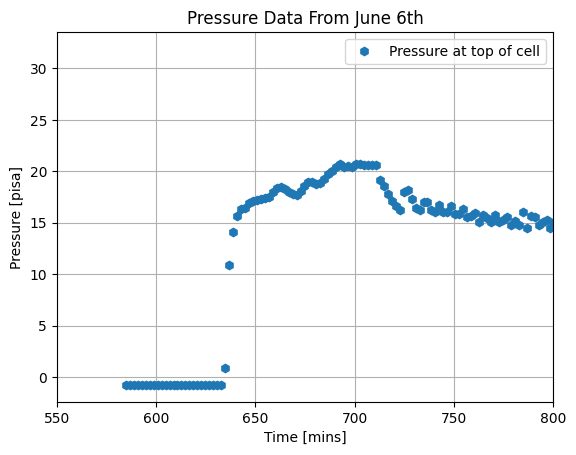

In [ ]:
date=20240606
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list =glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=40000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_June06_2=pd.concat(slowcontrol_dict_list)

plt.errorbar(DF_June06_2["Time"][::60]/60.0,DF_June06_2["Pressure_Cryostat"][::60], fmt="h", label="Pressure at top of cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_Top"][::60], fmt="x", label="Top of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()
plt.xlim(550,800)
#plt.ylim(160,220)
plt.title("Pressure Data From June 6th")
plt.xlabel("Time [mins]")
plt.ylabel("Pressure [pisa]")

['A:/DATA\\20240523_slow_control_2.h5', 'A:/DATA\\20240523_slow_control_3.h5', 'A:/DATA\\20240523_slow_control_5.h5', 'A:/DATA\\20240523_slow_control_8.h5']
Time offset 37645
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Bottom', 'tc08_daq/Xe_Cell_Outside', 'tc08_daq/Xe_Cell_Top'])
Not in channel list  Inter
Not in channel list  Slope
Not in channel list  Inter
Not in channel list  Slope
Time offset 39437
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'om

Text(0.5, 1.0, 'Thermocouple Data on May 23rd')

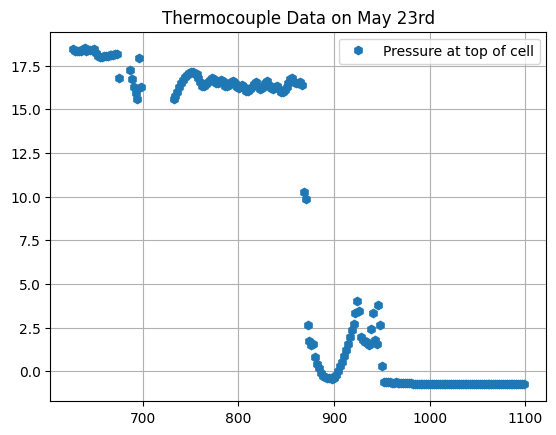

In [ ]:

date=20240523
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*_[2,3,5,8]*"
file_list = glob.glob(search_term)


print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=35000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF=pd.concat(slowcontrol_dict_list)

plt.errorbar(DF["Time"][::60]/60.0,DF["Pressure_Cryostat"][::60], fmt="h", label="Pressure at top of cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_Top"][::60], fmt="x", label="Top of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()
#plt.xlim(550,800)
#plt.ylim(160,220)
plt.title("Thermocouple Data on May 23rd")

Text(0.5, 1.0, 'Thermocouple Data on May 23rd')

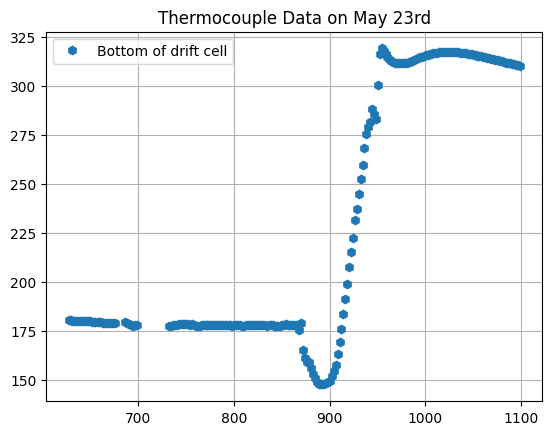

In [ ]:
plt.errorbar(DF["Time"][::60]/60.0,DF["Xe_Cell_Bottom"][::60], fmt="h", label="Bottom of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_Top"][::60], fmt="x", label="Top of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()
#plt.xlim(550,800)
#plt.ylim(160,220)
plt.title("Thermocouple Data on May 23rd")

In [ ]:
date=["20240202"]
type(date)

list

In [ ]:
date=20240528

print(GetAllFiles(date))
DF=Get_SlowControl_DF(date)


In [145]:
flow_threshold=0.0055


xenon_density_at_0C_1atm=(0.0058592+0.0059401)/2.0  # Density of gaseous xenon at 0C and 1 atm from a nist table  in [g/ml]- used psia of 14.6 and 14.8 to average for 14.7
xenon_flow_conversionfactor=1.32 # This is pulled from page 68 from the MKS manuel. Table of correction factors


flow_sum=0
a=[]
flow_intergration=0
flow_itergartion_list=[]
flow_running_sum=[]
flow_list=[]
for i,flow in enumerate(DF["Flow_Meter"]):
    if flow <= flow_threshold:
        flow=0     
    if i == 0 or i == len(DF["Flow_Meter"])-1:
        a.append(1)
    elif i%2 == 1:
        a.append(4)
    else:
        a.append(2)
    flow_list.append(flow)
    if flow>=5:
        print("Saturation")
    flow_intergration = (2/3) * sum(np.array(a)*np.array(flow_list))
    flow_itergartion_list.append(flow_intergration)

    flow_sum = flow*2+flow_sum
    flow_running_sum.append(flow_sum)


DF["Flow_Iter"] = flow_itergartion_list


xloc_of_mid=np.where(np.abs(DF["Flow_Meter"].diff(1500)) < 0.0000005)[0]
yval_of_mid=DF["Flow_Iter"].loc[np.where(DF["Flow_Meter"].diff(1500) < 0.0000005)[0][0]]
yval_of_end=DF["Flow_Iter"].loc[np.where(DF["Flow_Meter"].diff(1500) < 0.0000005)[0][-1]]
print(xloc_of_mid,yval_of_mid,yval_of_end)

Saturation
Saturation
Saturation
[ 5636  6701  6746 11316] 10133.816097259521 20716.33124987284


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Start of the day, since timezero 44323200.0
Start of file  44356782.0
Start of file  33582.0


Text(0.5, 0, 'Time ')

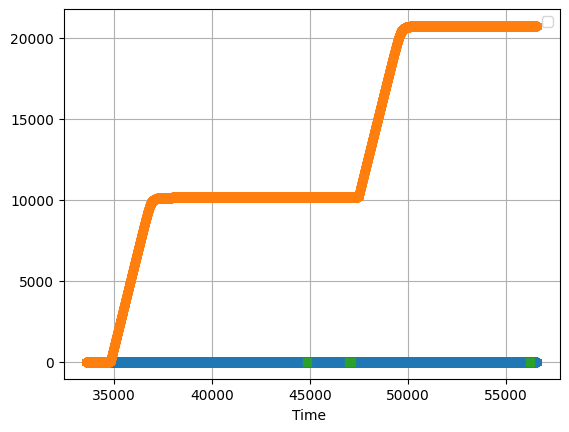

In [143]:


timeo=(datetime.datetime(2024,5,28,0,0,0)-TimeZero).total_seconds()
print("Start of the day, since timezero" ,timeo)
print("Start of file " ,DF["Time"].iloc[0])
print("Start of file ", DF["Time"].iloc[0]-timeo)


plt.errorbar(x=(DF["Time"][::])-timeo , y=DF["Flow_Meter"][::], fmt="h")

plt.errorbar(x=(DF["Time"][::])-timeo , y=DF["Flow_Iter"][::], fmt="h")
#plt.errorbar(x=(DF["Time"][::60]-timeo)/3600.0  , y=DF["Target_Channel"][::60])


x=DF["Time"][np.where(np.abs(DF["Flow_Meter"].diff(1500)) < 0.0000005)[0]] -timeo 
y=3*np.ones(len(x))
plt.errorbar(x,y,marker="s",fmt=" ")

June5_dt = datetime.datetime(2024,6,6)

June5_secs = (June5_dt - TimeZero).total_seconds()


#plt.errorbar(x=np.array([June5_secs,June5_secs])/60,y=[0,5])
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June
# 06["Xe_Cell_Top"][::60], fmt="x", label="Top of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Cryostat_Top"][::60], fmt="x", label="Top of cryo")
#plt
# .errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()
#plt.xlim(550,800)
#plt.ylim(4000,6000)
#plt.title("Thermocouple Data on June 6th")
plt.xlabel("Time ")

#plt.ylabel("Temperature [K]")
#plt.xlim(37500,49000)

<ErrorbarContainer object of 3 artists>

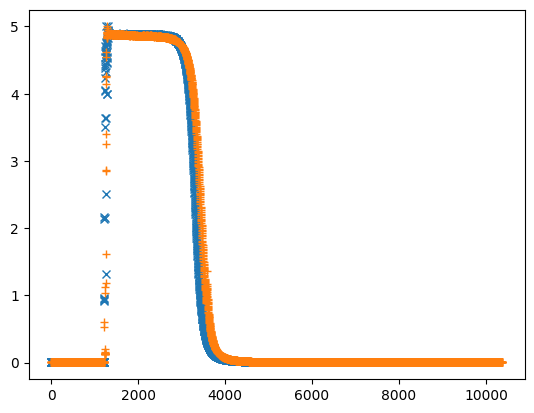

In [118]:
x1_stop=4000
x2_start=6310

x1=DF["Time"][:x1_stop]
y1=DF["Flow_Meter"][:x1_stop]

x2=DF["Time"][x2_start:]
y2=DF["Flow_Meter"][x2_start:]


plt.errorbar(x1-x1.iloc[0],y1,marker="x",fmt=" ")
plt.errorbar(x2-x2.iloc[0],y2,marker="+",fmt=" ")
#plt.xlim(1000,2000)







#### Total Flow sum for two complete pass cycles

In [60]:
# Pulls data from a double round of purification passes to attempt a flow meter itergration calibration
Calib_FlowIter_1 = 5080.177172
Calib_FlowIter_2 = 10371.57745-5080.177172

In [62]:
Calib_FlowIter_2/Calib_FlowIter_1

1.0415779014881965

In [159]:
date=20240528

print(GetAllFiles(date))
DF=Get_SlowControl_DF(date)

['A:/DATA\\20240528_slow_control.h5']
{'year': 2024, 'mon': 5, 'day': 28, 'hour': 9, 'min': 19, 'sec': 42} 2024-05-28 09:19:42
Time offset 44356782.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Bottom', 'tc08_daq/Xe_Cell_Outside', 'tc08_daq/Xe_Cell_Top'])
Not in channel list  Inter
Not in channel list  Slope
Not in channel list  Inter
Not in channel list  Slope


In [163]:



flow_threshold=0.0055


xenon_density_at_0C_1atm=(0.0058592+0.0059401)/2.0  # Density of gaseous xenon at 0C and 1 atm from a nist table - used psia of 14.6 and 14.8 to average for 14.7
xenon_flow_conversionfactor=1.32 # This is pulled from page 68 from the MKS manuel. Table of correction factors


flow_sum=0
a=[]
flow_intergration=0
flow_itergartion_list=[]
flow_running_sum=[]
flow_list=[]
for i,flow in enumerate(DF["Flow_Meter"]):
    if flow <= flow_threshold:
        flow=0     
    if i == 0 or i == len(DF["Flow_Meter"])-1:
        a.append(1)
    elif i%2 == 1:
        a.append(4)
    else:
        a.append(2)
    flow_list.append(flow*60*xenon_density_at_0C_1atm)
    if flow>=5:
        print("Saturation")
    flow_intergration = (2/3) * sum(np.array(a)*np.array(flow_list))
    flow_itergartion_list.append(flow_intergration)

    flow_sum = flow*2+flow_sum
    flow_running_sum.append(flow_sum)


DF["Flow_Iter"] = flow_itergartion_list


xloc_of_mid=np.where(np.abs(DF["Flow_Meter"].diff(1500)) < 0.0000005)[0]
yval_of_mid=DF["Flow_Iter"].loc[np.where(DF["Flow_Meter"].diff(1500) < 0.000005)[0][0]]
yval_of_end=DF["Flow_Iter"].loc[np.where(DF["Flow_Meter"].diff(1500) < 0.0000005)[0][-1]]

print(xloc_of_mid,yval_of_mid,yval_of_end)

Saturation
Saturation
Saturation
[ 5636  6701  6746 11316] 3587.158088291825 7333.146219498719


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Start of the day, since timezero 44323200.0
Start of file  44356782.0
Start of file  33582.0


Text(0.5, 0, 'Time ')

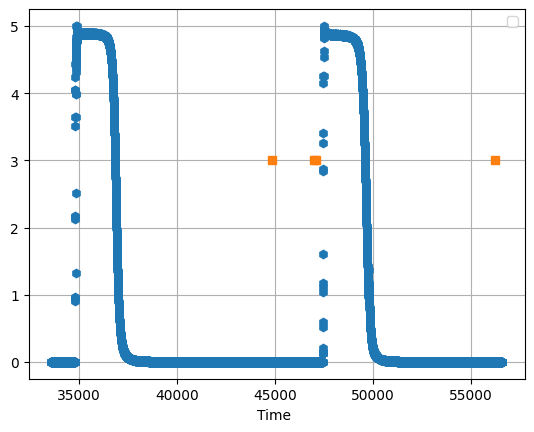

In [164]:


timeo=(datetime.datetime(2024,5,28,0,0,0)-TimeZero).total_seconds()
print("Start of the day, since timezero" ,timeo)
print("Start of file " ,DF["Time"].iloc[0])
print("Start of file ", DF["Time"].iloc[0]-timeo)


plt.errorbar(x=(DF["Time"][::])-timeo , y=DF["Flow_Meter"][::], fmt="h")

#plt.errorbar(x=(DF["Time"][::])-timeo , y=DF["Flow_Iter"][::], fmt="h")
#plt.errorbar(x=(DF["Time"][::60]-timeo)/3600.0  , y=DF["Target_Channel"][::60])


x=DF["Time"][np.where(np.abs(DF["Flow_Meter"].diff(1500)) < 0.0000005)[0]] -timeo 
y=3*np.ones(len(x))
plt.errorbar(x,y,marker="s",fmt=" ")

June5_dt = datetime.datetime(2024,6,6)

June5_secs = (June5_dt - TimeZero).total_seconds()


#plt.errorbar(x=np.array([June5_secs,June5_secs])/60,y=[0,5])
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June
# 06["Xe_Cell_Top"][::60], fmt="x", label="Top of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Cryostat_Top"][::60], fmt="x", label="Top of cryo")
#plt
# .errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()

#plt.xlim(550,800)
#plt.ylim(4000,6000)
#plt.title("Thermocouple Data on June 6th")
plt.xlabel("Time ")

#plt.ylabel("Temperature [K]")
#plt.xlim(37500,49000)